In [1]:
import sys
import math
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

In [3]:
from pydil.optimal_transport import OptimalTransportSolver
from pydil.optimal_transport import EmpiricalBarycenterSolver
from pydil.optimal_transport import JointWassersteinDistance

from pydil.empirical_dictionary import EmpiricalMeasure
from pydil.empirical_dictionary import LabeledEmpiricalMeasure
from pydil.empirical_dictionary import LabeledEmpiricalDictionary

from pydil.utils import visualize_gmm

2024-08-05 15:08:11.527993: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 15:08:11.529177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 15:08:11.552870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 15:08:11.941373: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
def make_classification_dataset(mean,
                                cov,
                                v=None,
                                separation=1,
                                n=200):
    x1 = np.random.multivariate_normal(mean, cov, size=n)
    if v is None:
        v = np.random.randn(2,)
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    elif np.linalg.norm(v) != separation:
        v = separation * (v / np.linalg.norm(v)).reshape(1, -1)
    else:
        v = v.reshape(1, -1)
    x2 = x1 + v
    X = np.concatenate([x1, x2], axis=0)
    y = np.array([0] * len(x1) + [1] * len(x2))

    return X, y

In [5]:
def msda_toy_example(n_datasets,
                     n_samples=400,
                     angle_min=0.0,
                     angle_max=45,
                     separation=6):
    mu = np.array([0, 0])
    angles = np.linspace(angle_min, angle_max, n_datasets)
    Xs, Ys = [], []
    for i in range(n_datasets - 1):
        A = np.random.randn(2, 2)
        cov = .25 * np.dot(A.T, A) + np.eye(2)
        v = np.array([np.cos((np.pi / 180) * angles[i]),
                      np.sin((np.pi / 180) * angles[i])])
        X, y = make_classification_dataset(mu, cov, v=v,
                                           separation=separation,
                                           n=n_samples)

        Xs.append(torch.from_numpy(X).float())
        Ys.append(
            torch.nn.functional.one_hot(torch.from_numpy(y).long(),
                                        num_classes=2).float())

    A = np.random.randn(2, 2)
    cov = .1 * np.dot(A.T, A) + np.eye(2)
    v = np.array([np.cos((np.pi / 180) * angles[-1]),
                  np.sin((np.pi / 180) * angles[-1])])
    Xt, yt = make_classification_dataset(mu, cov,
                                         v=v,
                                         separation=separation,
                                         n=n_samples)
    Xt = torch.from_numpy(Xt).float()
    Yt = torch.nn.functional.one_hot(
        torch.from_numpy(yt).long(), num_classes=2).float()

    return Xs, Ys, Xt, Yt

In [6]:
Xs, Ys, Xt, Yt = msda_toy_example(
    n_datasets=4,
    n_samples=500,
    angle_min=0,
    angle_max=30,
    separation=10)

In [7]:
true_features = Xs + [Xt,]
true_labels = Ys + [Yt,]

In [8]:
xmin, xmax = torch.cat(true_features, dim=0)[:, 0].min(), torch.cat(true_features, dim=0)[:, 0].max()
ymin, ymax = torch.cat(true_features, dim=0)[:, 1].min(), torch.cat(true_features, dim=0)[:, 1].max()
print(xmin, xmax, ymin, ymax)

tensor(-4.1520) tensor(14.1612) tensor(-4.6638) tensor(9.3174)


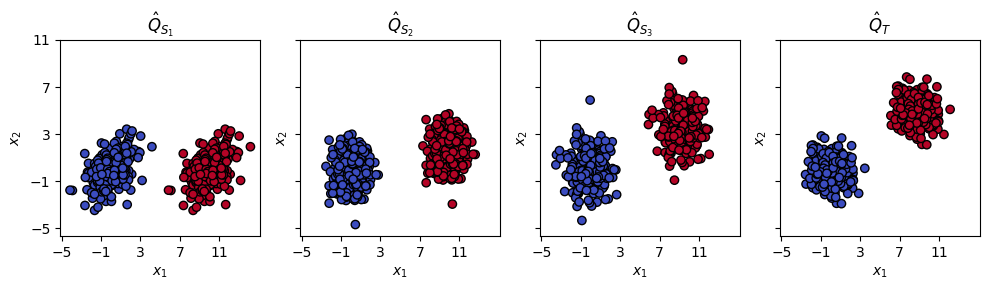

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharex=True, sharey=True)

for i, (Xi, Yi, ax) in enumerate(zip(true_features[:-1], true_labels[:-1], axes.flatten()[:-1])):
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

ax = axes.flatten()[-1]
Xi = true_features[-1]
Yi = true_labels[-1]
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')

plt.tight_layout()

In [32]:
source_measures = [
    LabeledEmpiricalMeasure(features=Xsk, labels=Ysk, batch_size=128, balanced_sampling=True)
    for Xsk, Ysk in zip(Xs, Ys)]

In [33]:
source_measures[0].sample()

(tensor([[ 0.9380,  1.2335],
         [-0.2478, -1.4006],
         [-2.6351, -3.0450],
         ...,
         [ 9.0660, -1.6342],
         [11.3501,  0.5676],
         [10.1838,  0.0945]]),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         ...,
         [0., 1.],
         [0., 1.],
         [0., 1.]]))

In [34]:
target_measure = EmpiricalMeasure(features=Xt, batch_size=128)

In [35]:
ot_solver = OptimalTransportSolver()
barycenter_solver = EmpiricalBarycenterSolver(
    n_samples=128,
    ot_solver=ot_solver,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True,
    init='random')
loss_fn = JointWassersteinDistance(
    ot_solver=ot_solver)

In [36]:
dictionary = LabeledEmpiricalDictionary(
    barycenter_solver,
    n_samples=1024,
    n_dim=2,
    n_classes=2,
    n_components=3,
    n_distributions=4,
    loss_fn=loss_fn,
    track_atoms=True,
    balanced_sampling=True
)

In [37]:
dictionary.fit(
    source_measures + [target_measure,],
    n_iter_max=50,
    batches_per_it=1024 // 128,
    verbose=True
)

  0%|          | 0/8 [00:00<?, ?it/s]

It 0/50, Loss: 265.34170722961426


  0%|          | 0/8 [00:00<?, ?it/s]

It 1/50, Loss: 195.80270957946777


  0%|          | 0/8 [00:00<?, ?it/s]

It 2/50, Loss: 162.81476402282715


  0%|          | 0/8 [00:00<?, ?it/s]

It 3/50, Loss: 139.68468856811523


  0%|          | 0/8 [00:00<?, ?it/s]

It 4/50, Loss: 124.46833610534668


  0%|          | 0/8 [00:00<?, ?it/s]

It 5/50, Loss: 110.09498310089111


  0%|          | 0/8 [00:00<?, ?it/s]

It 6/50, Loss: 95.92694187164307


  0%|          | 0/8 [00:00<?, ?it/s]

It 7/50, Loss: 87.5267858505249


  0%|          | 0/8 [00:00<?, ?it/s]

It 8/50, Loss: 76.58018684387207


  0%|          | 0/8 [00:00<?, ?it/s]

It 9/50, Loss: 68.17629814147949


  0%|          | 0/8 [00:00<?, ?it/s]

It 10/50, Loss: 60.720996379852295


  0%|          | 0/8 [00:00<?, ?it/s]

It 11/50, Loss: 54.08759164810181


  0%|          | 0/8 [00:00<?, ?it/s]

It 12/50, Loss: 48.13157558441162


  0%|          | 0/8 [00:00<?, ?it/s]

It 13/50, Loss: 41.361087799072266


  0%|          | 0/8 [00:00<?, ?it/s]

It 14/50, Loss: 36.3582820892334


  0%|          | 0/8 [00:00<?, ?it/s]

It 15/50, Loss: 32.605628490448


  0%|          | 0/8 [00:00<?, ?it/s]

It 16/50, Loss: 28.98980188369751


  0%|          | 0/8 [00:00<?, ?it/s]

It 17/50, Loss: 26.03080725669861


  0%|          | 0/8 [00:00<?, ?it/s]

It 18/50, Loss: 22.42770266532898


  0%|          | 0/8 [00:00<?, ?it/s]

It 19/50, Loss: 19.943081617355347


  0%|          | 0/8 [00:00<?, ?it/s]

It 20/50, Loss: 17.542901515960693


  0%|          | 0/8 [00:00<?, ?it/s]

It 21/50, Loss: 15.314845323562622


  0%|          | 0/8 [00:00<?, ?it/s]

It 22/50, Loss: 13.135989427566528


  0%|          | 0/8 [00:00<?, ?it/s]

It 23/50, Loss: 11.244209289550781


  0%|          | 0/8 [00:00<?, ?it/s]

It 24/50, Loss: 10.096464991569519


  0%|          | 0/8 [00:00<?, ?it/s]

It 25/50, Loss: 8.61223417520523


  0%|          | 0/8 [00:00<?, ?it/s]

It 26/50, Loss: 7.212157487869263


  0%|          | 0/8 [00:00<?, ?it/s]

It 27/50, Loss: 6.0115607380867


  0%|          | 0/8 [00:00<?, ?it/s]

It 28/50, Loss: 5.384774625301361


  0%|          | 0/8 [00:00<?, ?it/s]

It 29/50, Loss: 5.139225482940674


  0%|          | 0/8 [00:00<?, ?it/s]

It 30/50, Loss: 4.565131664276123


  0%|          | 0/8 [00:00<?, ?it/s]

It 31/50, Loss: 4.358663231134415


  0%|          | 0/8 [00:00<?, ?it/s]

It 32/50, Loss: 2.866063892841339


  0%|          | 0/8 [00:00<?, ?it/s]

It 33/50, Loss: 3.8791476488113403


  0%|          | 0/8 [00:00<?, ?it/s]

It 34/50, Loss: 2.6625546514987946


  0%|          | 0/8 [00:00<?, ?it/s]

It 35/50, Loss: 2.7995900213718414


  0%|          | 0/8 [00:00<?, ?it/s]

It 36/50, Loss: 3.2335411310195923


  0%|          | 0/8 [00:00<?, ?it/s]

It 37/50, Loss: 2.450885236263275


  0%|          | 0/8 [00:00<?, ?it/s]

It 38/50, Loss: 3.8005164563655853


  0%|          | 0/8 [00:00<?, ?it/s]

It 39/50, Loss: 2.0038567185401917


  0%|          | 0/8 [00:00<?, ?it/s]

It 40/50, Loss: 2.44752961397171


  0%|          | 0/8 [00:00<?, ?it/s]

It 41/50, Loss: 2.5855545699596405


  0%|          | 0/8 [00:00<?, ?it/s]

It 42/50, Loss: 2.4901390969753265


  0%|          | 0/8 [00:00<?, ?it/s]

It 43/50, Loss: 2.927054226398468


  0%|          | 0/8 [00:00<?, ?it/s]

It 44/50, Loss: 3.3386446684598923


  0%|          | 0/8 [00:00<?, ?it/s]

It 45/50, Loss: 2.0922828912734985


  0%|          | 0/8 [00:00<?, ?it/s]

It 46/50, Loss: 2.686449632048607


  0%|          | 0/8 [00:00<?, ?it/s]

It 47/50, Loss: 2.4195895344018936


  0%|          | 0/8 [00:00<?, ?it/s]

It 48/50, Loss: 2.241443857550621


  0%|          | 0/8 [00:00<?, ?it/s]

It 49/50, Loss: 2.1442127227783203


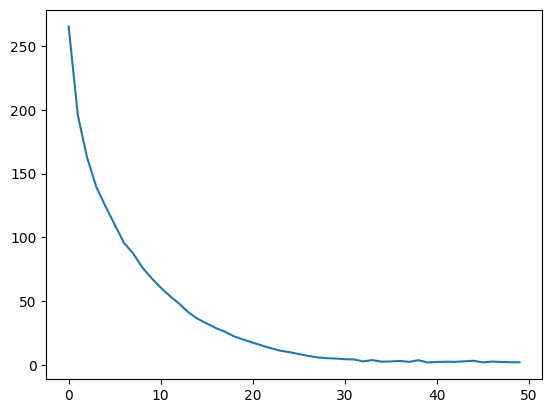

In [38]:
plt.plot(dictionary.history['loss'])

In [39]:
barycenter_solver2 = EmpiricalBarycenterSolver(
    n_samples=512,
    ot_solver=ot_solver,
    propagate_labels=True,
    penalize_labels=True)

In [40]:
XP, YP = dictionary.get_atoms()
YP = YP.softmax(dim=-1)
A = dictionary.get_barycentric_coordinates()

In [41]:
Xr, Yr = [], []
for coords in A:
    XB, YB = barycenter_solver2(XP, YP, coords)
    Xr.append(XB)
    Yr.append(YB)

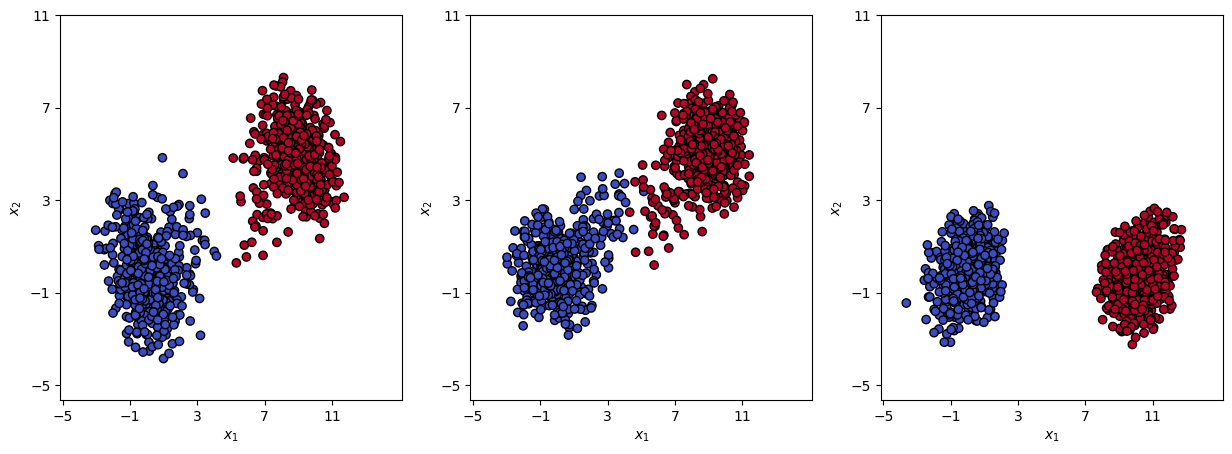

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(XP[0, :, 0], XP[0, :, 1], c=YP[0, :, 1], cmap='coolwarm', edgecolor='k')
axes[1].scatter(XP[1, :, 0], XP[1, :, 1], c=YP[1, :, 1], cmap='coolwarm', edgecolor='k')
axes[2].scatter(XP[2, :, 0], XP[2, :, 1], c=YP[2, :, 1], cmap='coolwarm', edgecolor='k')

for ax in axes:
    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

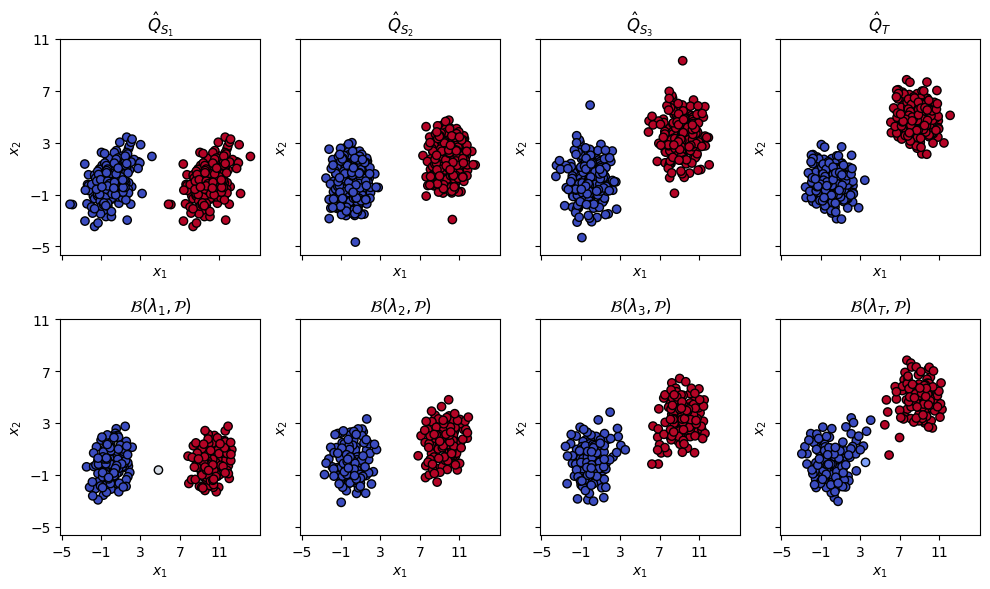

In [43]:
fig, axes = plt.subplots(2, 4, figsize=(10, 6), sharex=True, sharey=True)

for i, (Xi, Yi, Xri, Yri) in enumerate(zip(
     true_features[:-1], true_labels[:-1], Xr, Yr)):
    ax = axes[0, i]
    ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\hat{Q}_{S_{" + str(i + 1) + r"}}$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')
    
    ax = axes[1, i]
    ax.scatter(x=Xri[::2, 0], y=Xri[::2, 1], c=Yri[::2, 1], cmap='coolwarm', edgecolor='k')
    ax.set_title(r"$\mathcal{B}(\lambda_{" + str(i + 1) + r"}, \mathcal{P})$")

    ax.set_xlim([xmin - 1, xmax + 1])
    ax.set_ylim([ymin - 1, ymax + 1])

    ax.set_xticks([-5, -1, 3, 7, 11])
    ax.set_yticks([-5, -1, 3, 7, 11])

    ax.set_xlabel(r'$x_{1}$')
    ax.set_ylabel(r'$x_{2}$')

ax = axes[0, -1]
Xi = true_features[-1]
Yi = true_labels[-1]
ax.scatter(x=Xi[::2, 0], y=Xi[::2, 1], c=Yi[::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\hat{Q}_{T}$")

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')

ax = axes[1, -1]
ax.scatter(x=Xr[-1][::2, 0], y=Xr[-1][::2, 1], c=Yr[-1][::2, 1], cmap='coolwarm', edgecolor='k')
ax.set_title(r"$\mathcal{B}(\lambda_{T}, \mathcal{P})$")

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax.set_xticks([-5, -1, 3, 7, 11])
ax.set_yticks([-5, -1, 3, 7, 11])

ax.set_xlabel(r'$x_{1}$')
ax.set_ylabel(r'$x_{2}$')


plt.tight_layout()

In [48]:
coords_hist = torch.stack(dictionary.history['weights'])

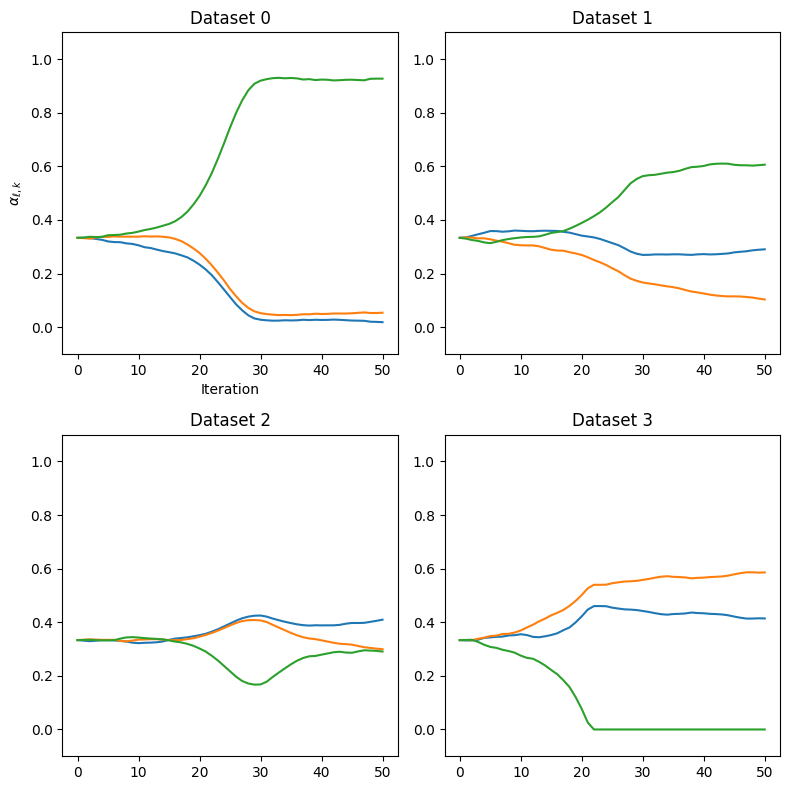

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.flatten()):
    for k in range(3):
        ax.plot(coords_hist[:, i, k], label='Atom {}'.format(k + 1))
    ax.set_title(f'Dataset {i}')
    ax.set_ylim([-0.1, 1.1])
axes[0, 0].set_ylabel(r'$\alpha_{\ell,k}$')
axes[0, 0].set_xlabel('Iteration')
plt.tight_layout()